In [1]:
conda install -c anaconda quandl

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import math, datetime
import quandl
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use('ggplot')

In [5]:
df = quandl.get('WIKI/GOOGL')
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0
df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  3.712563    0.324968   44659000.0
2004-08-20   54.322689  0.710922    7.227007   22834300.0
2004-08-23   54.869377  3.729433   -1.227880   18256100.0
2004-08-24   52.597363  6.417469   -5.726357   15247300.0
2004-08-25   53.164113  1.886792    1.183658    9188600.0


In [1]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)

forecast_out = int(math.ceil(0.01*len(df)))
print(forecast_out)

NameError: name 'df' is not defined

In [8]:
df['label'] = df[forecast_col].shift(-forecast_out)


X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)
    

accuracy = clf.score(X_test, y_test)
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[1012.03193433 1014.81585923 1013.49470665 1053.97554395 1056.53926269
 1056.57425685 1066.32845803 1067.24630419 1074.489046   1066.40258178
 1076.95842865 1071.87564465 1068.55224562 1065.07610684 1066.14542404
 1060.62529853 1072.74780011 1058.93008141 1058.80116539 1074.92566799
 1076.41275461 1081.04270636 1096.68143669 1086.50236232 1059.43999673
 1059.57496018 1047.99023409 1033.90002399 1041.82132759 1056.27839428
 1068.59961506 1073.29120474 1076.30245205 1071.95905792 1075.6376838 ] 0.9757337229089609 35


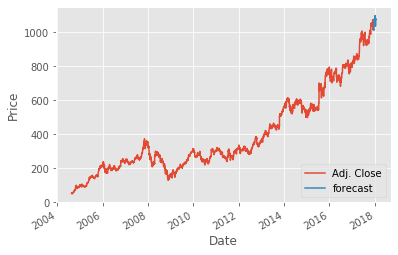

In [9]:
df['forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
    
df['Adj. Close'].plot()
df['forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()